In [1]:

import keras
from keras.models import model_from_json

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Load model

In [2]:
model = model_from_json(open('model.json').read())
model.load_weights('weights.h5')

Load images from directory

In [3]:
data_dir  = "SMILEs"

img_height = 64
img_width = 64

batch_size = 32

ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size
)

ds_pos = tf.keras.utils.image_dataset_from_directory(
  data_dir + "/positives",
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size
)

ds_neg = tf.keras.utils.image_dataset_from_directory(
  data_dir + "/negatives",
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size
)

Found 13165 files belonging to 2 classes.
Found 3690 files belonging to 1 classes.
Found 9475 files belonging to 1 classes.


Showing how accurate is the model

In [4]:
number_of_examples = 150

propabilities = []
for ds in [ds_pos, ds_neg]:
    for i in range(number_of_examples):
        if i%50 == 0: print(f"{i}th picture")
        propabilities.append(model.predict(ds.take(1))[0][0])

0th picture
50th picture
100th picture
0th picture
50th picture
100th picture


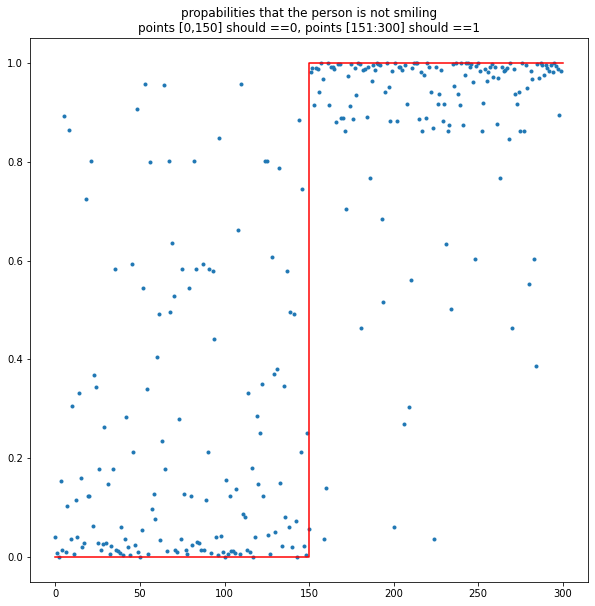

In [5]:
plt.figure(figsize=(10,10))
plt.plot([0,number_of_examples,number_of_examples,2*number_of_examples], [0,0,1,1], color='red')
plt.title(f"propabilities that the person is not smiling\npoints [0,{number_of_examples}] should ==0, points [{number_of_examples+1}:{2*number_of_examples}] should ==1")
plt.scatter(list(range(len(propabilities))), propabilities, marker='.')

Showing evaluation and GRAD-CAM on an example

In [6]:
def evaluate_example(img):
    global model
    p = model.predict(img)
    print(f"propability that person on a picture is not smiling: {p[0][0]}")
    print(f"propability that person on a picture is smiling: {p[0][1]}")


propability that person on a picture is not smiling: 0.06040138751268387
propability that person on a picture is smiling: 0.9395986199378967


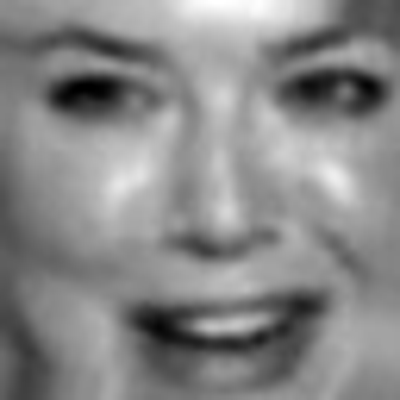

In [7]:
take = ds_pos.take(1)
for img, label in take:
    evaluate_example(img)
    img = keras.preprocessing.image.array_to_img(img[0])
    display(img.resize((400,400)))
    break

propability that person on a picture is not smiling: 0.9999971389770508
propability that person on a picture is smiling: 2.9139382604626007e-06
Evaluated picture:


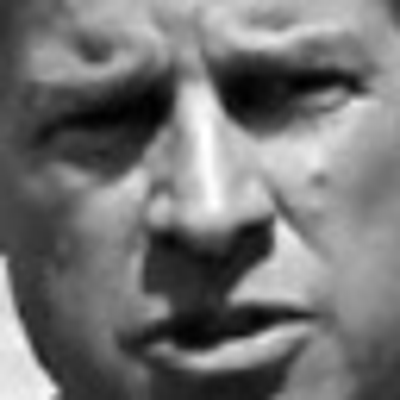

GRAD-CAM:


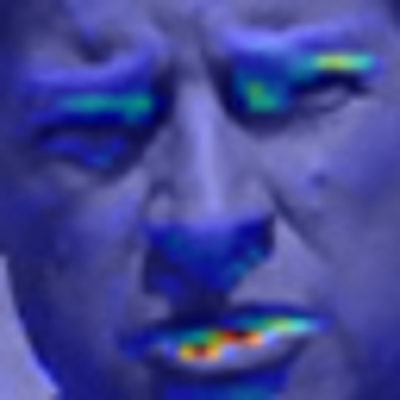

In [10]:
import matplotlib.cm as cm

from IPython.display import display

import keras.backend as K

import tensorflow as tf

def save_and_display_gradcam(alpha=0.5):
    # Take random batch from tf.dataset
    take = ds.take(1)
    for img, lab in take:
        image = img
        label = lab
    
    # Predict example and display it
    evaluate_example(image)
    image_wo_gradcam = keras.preprocessing.image.array_to_img(image[0])
    print("Evaluated picture:")
    display(image_wo_gradcam.resize((400,400)))
    
    # GRAD-CAM
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv2d_1')
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(image) # Get output of last conv layer in model and model output
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer) # Calculate the gradient between the class output and the convolutional layer output
        pooled_grads = K.mean(grads, axis=(0, 1, 2)) # Avarage gradient among all axes
                
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) # Get the final heatmap
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255* heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap[0])
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[2]))    
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)    
    
    # Superimpose the heatmap on original image
    superimposed_img = img[0] + jet_heatmap * alpha 
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    # Display Grad CAM
    print("GRAD-CAM:")
    display(superimposed_img.resize((400,400)))
    

save_and_display_gradcam(alpha=0.8)